In [ ]:
# https://storage.googleapis.com/chrome-for-testing-public/142.0.7444.59/win64/chromedriver-win64.zip

### Import Required Python Libraries

In [1]:
import os
import time
from time import sleep
import pandas as pd
import datetime
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from functools import reduce
from dateutil import parser

pd.set_option('display.float_format', '{:,.2f}'.format)


### Define all helper function

In [3]:
def select_dropdown(driver, value):
    input_box = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "input[placeholder='Select Data']"))
    )

    # Click + clear previous value if any
    input_box.click()
    input_box.send_keys(Keys.CONTROL + "a")
    input_box.send_keys(Keys.DELETE)

    # Type option text
    input_box.send_keys(value)

    # Wait for dropdown list to appear and click the exact item
    option = WebDriverWait(driver, 10).until(
        EC.visibility_of_element_located((By.XPATH, f"//li[normalize-space()='{value}']"))
    )
    option.click()

def select_fin_year(driver, year_text):
    # 1️⃣ Click the dropdown arrow
    dropdown_btn = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "input[placeholder='Select Financial Year']"))
    )
    dropdown_btn.click()
    
    # 2️⃣ Wait for the list to load
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "//li[@role='option']"))
    )

    # 3️⃣ Scroll until your target year is visible (if needed)
    target_option_xpath = f"//li[normalize-space()='{year_text}']"
    option = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, target_option_xpath))
    )

    # 4️⃣ Click the option
    option.click()

def select_period(driver, period_text):
    # Click inside the Select Period dropdown
    period_input = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "input[placeholder='Select Period']"))
    )
    period_input.click()

    # Wait for list to appear and select matching period
    option_xpath = f"//li[normalize-space()='{period_text}']"
    option = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, option_xpath))
    )
    option.click()

def sort_columns_and_keep_total_last(df):
    id_col = df.columns[0]  # e.g. "Mutual Fund Name"
    
    # Identify quarter columns (all except first)
    quarter_cols = [col for col in df.columns if col != id_col]

    # Function to extract sortable date from column text
    def extract_date(col_name):
        # Remove "Total AUM" prefix
        parts = col_name.replace("Total AUM", "").strip()
        months = parts.split('-')
        end_month_year = months[-1].strip()  # e.g. "September 2025"
        return parser.parse(end_month_year)  # datetime object
    
    # Sort quarter columns by extracted date (DESC)
    col_date_pairs = [(col, extract_date(col)) for col in quarter_cols]
    sorted_cols = [col for col, dt in sorted(col_date_pairs, key=lambda x: x[1], reverse=True)]

    # Rebuild dataframe with sorted columns
    df_sorted = df[[id_col] + sorted_cols]

    # --- Keep Grand Total row last ---
    # Detect row where Mutual Fund Name == "Grand Total"
    mask_total = df_sorted[id_col].astype(str).str.lower() == "grand total".lower()

    df_main = df_sorted[~mask_total]   # all except total
    df_total = df_sorted[mask_total]   # the total row only

    # Concatenate so total stays at bottom
    final_df = pd.concat([df_main, df_total], ignore_index=True)

    return final_df

In [26]:
from datetime import date

def generate_financial_years(start_year: int, end_year: int):
    """
    Generates financial years and detailed quarter information
    based on Indian Financial Year (April–March structure).

    Returns:
        List of dictionaries, where each dictionary represents
        one financial year and contains 4 quarters with:
        - quarter name (Q1–Q4)
        - period text (e.g. 'April – June 2024')
        - start_date (datetime.date)
        - end_date (datetime.date)
        - financial_year (text)
    """
    
    # Month ranges for each quarter
    quarter_structure = [
        ("Q1", "April", 4, "June", 6),
        ("Q2", "July", 7, "September", 9),
        ("Q3", "October", 10, "December", 12),
        ("Q4", "January", 1, "March", 3),
    ]

    financial_years = []

    for fy_start in range(start_year, end_year):
        fy_end = fy_start + 1
        fy_label = f"April {fy_start} - March {fy_end}"

        quarters = []
        
        for q_name, start_month_name, start_month, end_month_name, end_month in quarter_structure:

            # Determine correct calendar year for each quarter
            if q_name in ("Q1", "Q2", "Q3"):  # belongs to start year
                year_start = fy_start
                year_end = fy_start
            else:  # Q4 belongs to next calendar year
                year_start = fy_end
                year_end = fy_end
            
            start_date = date(year_start, start_month, 1)
            end_day = 30 if end_month in (4, 6, 9, 11) else (29 if (year_end % 4 == 0 and end_month == 2) else 31)
            end_date = date(year_end, end_month, end_day)
            
            period_str = f"{start_month_name} - {end_month_name} {year_start if q_name != 'Q4' else year_end}"

            quarters.append({
                "financial_year": fy_label,
                "quarter": q_name,
                "period": period_str,
                "start_date": start_date,
                "end_date": end_date
            })

        financial_years.append({
            "financial_year": fy_label,
            "quarters": quarters
        })
    
    return financial_years

In [28]:
# Generate FY 2024-25 and 2025-26
data_list = generate_financial_years(2024, 2026)
data_list

[{'financial_year': 'April 2024 - March 2025',
  'quarters': [{'financial_year': 'April 2024 - March 2025',
    'quarter': 'Q1',
    'period': 'April - June 2024',
    'start_date': datetime.date(2024, 4, 1),
    'end_date': datetime.date(2024, 6, 30)},
   {'financial_year': 'April 2024 - March 2025',
    'quarter': 'Q2',
    'period': 'July - September 2024',
    'start_date': datetime.date(2024, 7, 1),
    'end_date': datetime.date(2024, 9, 30)},
   {'financial_year': 'April 2024 - March 2025',
    'quarter': 'Q3',
    'period': 'October - December 2024',
    'start_date': datetime.date(2024, 10, 1),
    'end_date': datetime.date(2024, 12, 31)},
   {'financial_year': 'April 2024 - March 2025',
    'quarter': 'Q4',
    'period': 'January - March 2025',
    'start_date': datetime.date(2025, 1, 1),
    'end_date': datetime.date(2025, 3, 31)}]},
 {'financial_year': 'April 2025 - March 2026',
  'quarters': [{'financial_year': 'April 2025 - March 2026',
    'quarter': 'Q1',
    'period': '

In [20]:
# Set up Selenium options
options = Options()
options.add_argument('--start-maximized')
# options.add_argument('--headless')  # Uncomment if running headless

# Update this path to your local chromedriver path
service = Service(r"C:\Users\Nileshs\Downloads\chromedriver-win64\chromedriver-win64\chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)
driver.get("https://www.amfiindia.com/aum-data/average-aum")

In [38]:
all_period_aum = []

for fy in data_list:                          # loop financial years
    for data in fy['quarters']:               # loop each quarter inside
        try:
            select_dropdown(driver, "Fundwise")
            select_fin_year(driver, data['financial_year'])
            select_period(driver, data['period'])

            go_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[normalize-space()='Go']"))
            )
            go_button.click()
            sleep(10)

            df = pd.read_html(driver.page_source)[0]
            df.columns = ["Sr No", "Mutual Fund Name",
                          f"AAUM for Quarter {data['period']}",
                          f"Fund Of Funds {data['period']}"]
            df = df.drop("Sr No", axis=1)

            all_period_aum.append(df)
        
        except Exception as e:
            print(f"❌ Not done for {data['financial_year']} - {data['quarter']}")
            pass

C:\Users\Nileshs\AppData\Local\Temp\ipykernel_15408\446787701.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(driver.page_source)[0]
C:\Users\Nileshs\AppData\Local\Temp\ipykernel_15408\446787701.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(driver.page_source)[0]
C:\Users\Nileshs\AppData\Local\Temp\ipykernel_15408\446787701.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(driver.page_source)[0]
C:\Users\Nileshs\AppData\Local\Temp\ipykernel_15408\446787701.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in 

❌ Not done for April 2025 - March 2026 - Q3
❌ Not done for April 2025 - March 2026 - Q4


In [42]:
final_df = reduce(lambda left, right: pd.merge(left, right, on="Mutual Fund Name", how="outer"), all_period_aum)

In [46]:
final_df.to_csv("Data for AUM.csv")

In [48]:
def build_total_aum_df(df):
    """
    Takes merged dataframe with columns:
    ['Mutual Fund Name', 'AAUM for Quarter ...', 'Fund Of Funds ...']
    Returns new dataframe with Total AUM per quarter.
    """

    # 1️⃣ Detect quarter labels dynamically from columns
    quarters = sorted(list(set(
        col.replace("AAUM for Quarter ", "").replace("Fund Of Funds ", "")
        for col in df.columns if col != "Mutual Fund Name"
    )))

    # 2️⃣ Create total columns in a copy (so original df is untouched)
    df2 = df.copy()
    for q in quarters:
        aaum_col = f"AAUM for Quarter {q}"
        fof_col = f"Fund Of Funds {q}"
        total_col = f"Total AUM {q}"
        df2[total_col] = df2[aaum_col] + df2[fof_col]

    # 3️⃣ Extract only MF name + Total columns
    total_cols = ["Mutual Fund Name"] + [c for c in df2.columns if c.startswith("Total AUM")]
    result_df = df2[total_cols]

    # 4️⃣ Sort Total AUM columns so latest quarter appears first
    total_aum_cols_sorted = sorted(result_df.columns[1:], reverse=True)
    result_df = result_df[["Mutual Fund Name"] + total_aum_cols_sorted]

    return result_df

In [50]:
total_aum_df = build_total_aum_df(final_df)

In [52]:
clean_df = sort_columns_and_keep_total_last(total_aum_df)

In [56]:
def compute_qoq_growth(df):
    id_col = df.columns[0]     # "Mutual Fund Name"
    latest = df.columns[1]     # Most recent quarter
    prev = df.columns[2]       # Previous quarter

    df['qoq_growth_pct'] = ((df[latest] - df[prev]) / df[prev]) * 100
    return df

In [58]:
def get_top_5_gainers(df):
    df_filtered = df[df['Mutual Fund Name'].str.lower() != 'grand total']
    df_sorted = df_filtered.sort_values(by='qoq_growth_pct', ascending=False)
    return df_sorted.head(5)

In [60]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

def plot_top_5_qoq(top5_df):
    plt.figure(figsize=(10,5))
    plt.bar(top5_df['Mutual Fund Name'], top5_df['qoq_growth_pct'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("QoQ Growth (%)")
    plt.title("Top 5 Fund Houses by QoQ AUM Growth")
    plt.tight_layout()
    plt.show()

In [62]:
df_with_growth = compute_qoq_growth(clean_df)

top5 = get_top_5_gainers(df_with_growth)

In [74]:
clean_df

,Mutual Fund Name,Total AUM July - September 2025,Total AUM April - June 2025,Total AUM January - March 2025,Total AUM October - December 2024,Total AUM July - September 2024,Total AUM April - June 2024,qoq_growth_pct
0,360 ONE Mutual Fund,"1,295,984.50","1,198,031.91","1,134,200.32","1,180,518.98","1,178,380.21","1,034,272.55",8.18
1,Aditya Birla Sun Life Mutual Fund,"42,806,594.43","40,526,675.85","38,288,963.22","38,499,993.92","38,432,688.85","35,351,739.69",5.63
2,Angel One Mutual Fund,"36,433.13","19,700.33","1,884.89",0.00,0.00,0.00,84.94
3,Axis Mutual Fund,"35,436,232.17","33,739,856.76","32,286,093.84","32,727,817.58","31,338,724.10","29,297,702.89",5.03
4,Bajaj Finserv Mutual Fund,"2,922,598.64","2,410,952.89","2,013,325.84","1,845,632.16","1,559,267.47","1,113,641.14",21.22
5,Bandhan Mutual Fund,"18,771,611.29","17,737,819.40","16,733,884.46","16,864,099.62","15,702,340.49","14,496,499.84",5.83
6,Bank of India Mutual Fund,"1,342,849.90","1,245,769.25","1,151,835.95","1,150,332.71","1,033,572.97","795,028.52",7.79
7,Baroda BNP Paribas Mutual Fund,"5,075,322.31","4,844,114.09","4,554,083.03","4,679,090.10","4,517,419.41","3,850,222.64",4.77
8,Canara Robeco Mutual Fund,"11,972,686.35","11,105,244.90","10,334,427.39","10,836,626.98","10,684,015.92","9,468,468.68",7.81
9,Capitalmind Mutual Fund,"6,919.04",0.00,NaN,NaN,NaN,NaN,inf


In [ ]:
clean_df.to_csv("Average AUM Trend.csv")
os.startfile("Average AUM Trend.csv")

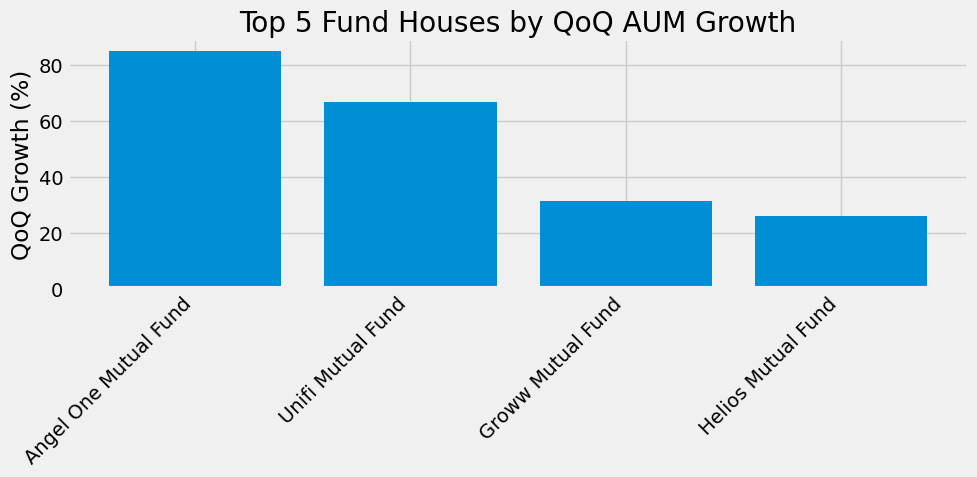

In [64]:
plot_top_5_qoq(top5)